# How to combine control flow and state updates with Command

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
      This guide assumes familiarity with the following:
      <ul>
        <li><a href="/langgraphjs/concepts/low_level/#state">State</a></li>
        <li><a href="/langgraphjs/concepts/low_level/#nodes">Nodes</a></li>
        <li><a href="/langgraphjs/concepts/low_level/#edges">Edges</a></li>
        <li><a href="/langgraphjs/concepts/low_level/#command">Command</a></li>
      </ul>
      <p>
        This functionality also requires <code>@langchain/langgraph>=0.2.29</code>.
      </p>
    </p>
</div>

It can be useful to combine control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node. LangGraph provides a way to do so by returning a `Command` object from node functions:

```ts
const myNode = (state: typeof StateAnnotation.State) => {
  return new Command({
    // state update
    update: {
      foo: "bar",
    },
    // control flow
    goto: "myOtherNode",
  });
};
```

If you are using [subgraphs](/langgraphjs/concepts/low_level/#subgraphs), you might want to navigate from a node a subgraph to a different subgraph (i.e. a different node in the parent graph). To do so, you can specify `graph: Command.PARENT` in Command:

```ts
const myNode = (state: typeof StateAnnotation.State) => {
  return new Command({
    update: { foo: "bar" },
    goto: "other_subgraph", // where `other_subgraph` is a node in the parent graph
    graph: Command.PARENT,
  });
};
```

This guide shows how you can use `Command` to add dynamic control flow in your LangGraph app.

## Setup

First, let's install the required packages:

```bash
yarn add @langchain/langgraph @langchain/core
```

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

Let's create a simple graph with 3 nodes: A, B and C. We will first execute node A, and then decide whether to go to Node B or Node C next based on the output of node A.

## Define graph

In [1]:
import { Annotation, Command } from "@langchain/langgraph";

// Define graph state
const StateAnnotation = Annotation.Root({
  foo: Annotation<string>,
});

// Define the nodes
const nodeA = async (_state: typeof StateAnnotation.State) => {
  console.log("Called A");
  // this is a replacement for a real conditional edge function
  const goto = Math.random() > .5 ? "nodeB" : "nodeC";
  // note how Command allows you to BOTH update the graph state AND route to the next node
  return new Command({
    // this is the state update
    update: {
      foo: "a",
    },
    // this is a replacement for an edge
    goto,
  });
};

// Nodes B and C are unchanged
const nodeB = async (state: typeof StateAnnotation.State) => {
  console.log("Called B");
  return {
    foo: state.foo + "|b",
  };
}

const nodeC = async (state: typeof StateAnnotation.State) => {
  console.log("Called C");
  return {
    foo: state.foo + "|c",
  };
}

We can now create the `StateGraph` with the above nodes. Notice that the graph doesn't have [conditional edges](/langgraphjs/concepts/low_level#conditional-edges) for routing! This is because control flow is defined with `Command` inside `nodeA`.

In [2]:
import { StateGraph } from "@langchain/langgraph";

// NOTE: there are no edges between nodes A, B and C!
const graph = new StateGraph(StateAnnotation)
  .addNode("nodeA", nodeA, {
    ends: ["nodeB", "nodeC"],
  })
  .addNode("nodeB", nodeB)
  .addNode("nodeC", nodeC)
  .addEdge("__start__", "nodeA")
  .compile();

<div class="admonition tip">
    <p class="admonition-title">Important</p>
    <p>
      You might have noticed that we add an <code>ends</code> field as an extra param to the node where we use <code>Command</code>. This is necessary for graph compilation and validation, and tells LangGraph that <code>nodeA</code> can navigate to <code>nodeB</code> and <code>nodeC</code>.
    </p>
</div>

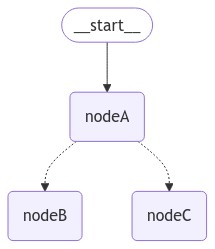

In [3]:
import * as tslab from "tslab";

const drawableGraph = await graph.getGraphAsync();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

If we run the graph multiple times, we'd see it take different paths (A -> B or A -> C) based on the random choice in node A.

In [4]:
await graph.invoke({ foo: "" });

Called A
Called B
{ foo: 'a|b' }


## Navigating to a node in a parent graph

Now let's demonstrate how you can navigate from inside a subgraph to a different node in a parent graph. We'll do so by changing `node_a` in the above example into a single-node graph that we'll add as a subgraph to our parent graph.

In [9]:
// Define the nodes
const nodeASubgraph = async (_state: typeof StateAnnotation.State) => {
  console.log("Called A");
  // this is a replacement for a real conditional edge function
  const goto = Math.random() > .5 ? "nodeB" : "nodeC";
  // note how Command allows you to BOTH update the graph state AND route to the next node
  return new Command({
    update: {
      foo: "a",
    },
    goto,
    // this tells LangGraph to navigate to node_b or node_c in the parent graph
    // NOTE: this will navigate to the closest parent graph relative to the subgraph
    graph: Command.PARENT,
  });
};

const subgraph = new StateGraph(StateAnnotation)
  .addNode("nodeA", nodeASubgraph)
  .addEdge("__start__", "nodeA")
  .compile();

const parentGraph= new StateGraph(StateAnnotation)
  .addNode("subgraph", subgraph, { ends: ["nodeB", "nodeC"] })
  .addNode("nodeB", nodeB)
  .addNode("nodeC", nodeC)
  .addEdge("__start__", "subgraph")
  .compile();
  
await parentGraph.invoke({ foo: "" });

Called A
Called C
{ foo: 'a|c' }
